### Metis Data Science Bootcamp - Final Project  
### Topic:  Prescription Drug Abuse in America  
This notebook contains the analysis of two years (2013-2014) of data from the National Survey on Drug Use and Health (NSDUH), the largest nationwide survey of substance abuse and mental health topics.  
Citation:  United States Department of Health and Human Services. Substance Abuse and Mental Health Services Administration. Center for Behavioral Health Statistics and Quality. National Survey on Drug Use and Health, 2013 and 2014.  

In [1]:
import numpy as np
import pandas as pd

from sklearn import cross_validation
from sklearn.cross_validation import train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.feature_selection import RFE, SelectKBest, chi2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
roc_auc_score, roc_curve, auc, classification_report, confusion_matrix)
from sklearn.grid_search import GridSearchCV

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Import the data for preprocessing and cleaning

In [2]:
master2013DF = pd.read_table('2013_nsduh.tsv')
master2014DF = pd.read_table('2014_nsduh.tsv')

In [3]:
master2013DF.tail()

,CASEID,QUESTID2,CIGEVER,CIGOFRSM,CIGWILYR,CIGTRY,CIGYFU,CIGMFU,CIGREC,CIG30USE,...,WORKRAND,EMPSTATY,IIEMPSTY,II2EMSTY,EMPSTAT4,IIEMPST4,II2EMST4,PDEN00,COUTYP2,MAIIN002
55155,55156,13675473,2,99,99,991,9991,91,91,91,...,3,2,1,1,2,1,1,3,3,2
55156,55157,49609908,1,99,99,16,9999,99,4,93,...,3,1,1,1,1,1,1,2,2,2
55157,55158,81795924,2,99,99,991,9991,91,91,91,...,99,4,1,1,4,1,1,3,3,2
55158,55159,17198338,2,4,4,991,9991,91,91,91,...,99,99,9,9,99,9,9,1,1,2
55159,55160,55989934,2,99,99,991,9991,91,91,91,...,3,1,1,1,1,1,1,3,3,2


In [4]:
master2014DF.head()

,CASEID,QUESTID2,CIGEVER,CIGOFRSM,CIGWILYR,CIGTRY,CIGYFU,CIGMFU,CIGREC,CIG30USE,...,WORKRAND,EMPSTATY,IIEMPSTY,II2EMSTY,EMPSTAT4,IIEMPST4,II2EMST4,PDEN10,COUTYP2,MAIIN102
0,1,85314767,1,99,99,16,9999,99,4,93,...,99,4,1,1,4,1,1,2,2,2
1,2,16240983,1,99,99,16,9999,99,1,1,...,3,2,1,1,2,1,1,1,1,2
2,3,95206287,2,99,99,991,9991,91,91,91,...,1,1,1,1,1,1,1,2,2,2
3,4,91546127,2,99,99,991,9991,91,91,91,...,3,1,1,1,1,1,1,1,1,2
4,5,43902390,2,99,99,991,9991,91,91,91,...,1,1,1,1,1,1,1,1,1,2


In [5]:
badvalues = [81, 85, 94, 97, 98, 99, 994, 997, 998]
cols_to_keep = ['CIGEVER', 'ALCEVER', 'ANLEVER', 'AGE2', 'GOVTPROG', 'INCOME', 'POVERTY2', 'ANYHLTI2','SERVICE',
                'IRSEX', 'IRMARIT', 'NEWRACE2', 'EDUCCAT2', 'HEALTH', 'MOVEPYR2', 'EMPSTATY', 'COUTYP2', 'SNRLGIMP',
                'DSTNRV30', 'ADDPREV', 'RKFQRSKY']

In [6]:
# Define a function to pre-process and clean the dataframes
def pandas_cleaner(dataframe, badvalues, cols_to_keep):
    # Remove leading whitespace from column names
    dataframe.rename(columns=lambda x: x.strip(), inplace=True)
    # Remove bad value from the ANLEVER column
    dataframe.ANLEVER = dataframe.ANLEVER.replace(91, 0)
    # Remove bad values (blanks, skips, NaNs, etc.) from specific columns
    dataframe = dataframe[~dataframe.ANLEVER.isin(badvalues)] 
    dataframe = dataframe[~dataframe.SERVICE.isin(badvalues)]
    dataframe = dataframe[~dataframe.IRMARIT.isin(badvalues)]
    dataframe = dataframe[~dataframe.HEALTH.isin(badvalues)]
    dataframe = dataframe[~dataframe.ANYHLTI2.isin(badvalues)]
    dataframe = dataframe[~dataframe.SNRLGIMP.isin(badvalues)]
    dataframe = dataframe[~dataframe.DSTNRV30.isin(badvalues)]
    dataframe = dataframe[~dataframe.ADDPREV.isin(badvalues)]
    dataframe = dataframe[~dataframe.RKFQRSKY.isin(badvalues)]
    # Remove all columns except for the columns of interest
    dataframe = dataframe[cols_to_keep]
    return dataframe

In [7]:
new2013DF = pandas_cleaner(master2013DF, badvalues, cols_to_keep)

In [8]:
new2014DF = pandas_cleaner(master2014DF, badvalues, cols_to_keep)

#### Check the value counts for the feature we will be using as our y variable (regressand, what we're predicting). ANLEVER is the response to the question in the survey: "Have you ever used prescription drugs non-medically?".  

In [9]:

new2013DF['ANLEVER'].value_counts()

0    29664
1     6559
Name: ANLEVER, dtype: int64

In [10]:
new2014DF['ANLEVER'].value_counts()

0    33501
1     6752
Name: ANLEVER, dtype: int64

#### Merge the two cleaned datasets together.  

In [11]:
cleanDF = new2013DF.append(new2014DF, ignore_index=True)

In [12]:
cleanDF['ANLEVER'].value_counts()

0    63165
1    13311
Name: ANLEVER, dtype: int64

### Modeling (Classification)
**In this section, we perform apply various classification algorithms against a training data set to develop a model, test the model with a test data set, examine the results, and extract feature importance to see which features are most closely correlated with prescription drug abuse.**    

In [13]:
y = cleanDF.ANLEVER

In [14]:
y.value_counts()

0    63165
1    13311
Name: ANLEVER, dtype: int64

In [15]:
cleanDF.drop('ANLEVER', axis=1, inplace=True)

In [16]:
X = cleanDF[['CIGEVER', 'ALCEVER', 'AGE2', 'GOVTPROG', 'INCOME', 'POVERTY2', 'ANYHLTI2','SERVICE','IRSEX', 'IRMARIT',
             'NEWRACE2', 'EDUCCAT2', 'HEALTH', 'MOVEPYR2', 'EMPSTATY', 'COUTYP2', 'SNRLGIMP','DSTNRV30', 'ADDPREV',
             'RKFQRSKY']]

In [17]:
sss = StratifiedShuffleSplit(y, n_iter=1, test_size=0.3, random_state=4444)
len(sss)

1

In [18]:
for train_index, test_index in sss:
    X_train, X_test = X.iloc[train_index],X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [20]:
models = [LogisticRegression(class_weight='balanced'), GaussianNB(), DecisionTreeClassifier(class_weight='balanced'), 
          RandomForestClassifier(class_weight='balanced', n_estimators=1000)]

In [21]:
# Define a function to fit the model for each classifier, predict using the test set and get accuracy, precision,
# recall, and F1 scores to assess the models performance
def score_machine(models, X_train, y_train, X_test, y_test):
    for model in models:
        model.fit(X_train, y_train)
        model_name = str(model).split('(')[0]
        print(model_name, "Results")
        print("Accuracy score:\t", accuracy_score(y_test, model.predict(X_test)))
        print("Precision:\t", precision_score(y_test, model.predict(X_test), pos_label=1, average='binary'))
        print("Recall:\t\t", recall_score(y_test, model.predict(X_test), pos_label=1, average='binary'))
        print("F1 Score:\t", f1_score(y_test, model.predict(X_test), pos_label=1, average='binary'), '\n')

In [22]:
score_machine(models, X_train, y_train, X_test, y_test)

LogisticRegression Results
Accuracy score:	 0.673582356274
Precision:	 0.311434735707
Recall:		 0.723015276734
F1 Score:	 0.435346452537 

GaussianNB Results
Accuracy score:	 0.670574903021
Precision:	 0.307151357784
Recall:		 0.71099423992
F1 Score:	 0.428981565428 

DecisionTreeClassifier Results
Accuracy score:	 0.744366473434
Precision:	 0.27358490566
Recall:		 0.28324567994
F1 Score:	 0.278331487634 

RandomForestClassifier Results
Accuracy score:	 0.820468116637
Precision:	 0.431670281996
Recall:		 0.0996744302529
F1 Score:	 0.161953204476 



#### Try some out of the box Gradient Boosted Tree Classification

In [23]:
gradboost = GradientBoostingClassifier(loss='deviance', n_estimators=1000, max_depth=6, max_features='auto')

In [24]:
gradboost.fit(X_train, y_train)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=6, max_features='auto', max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [26]:
gradboost_predict = gradboost.predict(X_test)
accuracy = accuracy_score(y_test, gradboost_predict)
precision = precision_score(y_test, gradboost_predict, average='binary')
recall = recall_score(y_test, gradboost_predict, average='binary')
print("Accuracy score:\t", accuracy)
print("Precision:\t", precision)
print("Recall:\t\t", recall)

Accuracy score:	 0.816632524081
Precision:	 0.434194341943
Recall:		 0.176809416479


In [27]:
y_scores = gradboost.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
auc = roc_auc_score(y_test, y_scores)
print("AUC:\t", auc)

AUC:	 0.726759890494


In [28]:
# Define a function that gets feature importance for the specific model passed as an argument to the function
def rank_features(model):
    # Get Feature Importance from the classifier
    feature_importance = model.feature_importances_
    # Normalize The Features
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.figure(figsize=(12, 8))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, np.asanyarray(cleanDF.columns.tolist())[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Feature Importance')
    plt.show()

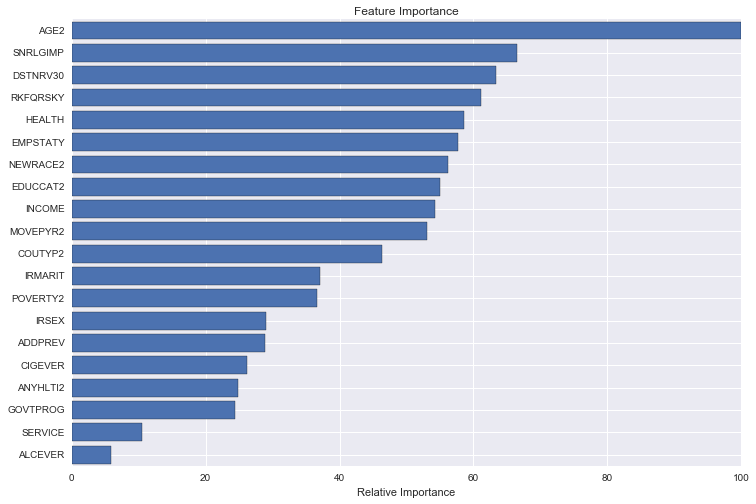

In [29]:
rank_features(gradboost)

#### Perform Grid Search Cross-Validation to tune the hyperparameters on a given model to try to improve performance

In [30]:
param_test1 = {'n_estimators': [20,30,40,50,60,70,80]}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=8, max_features='sqrt', max_leaf_nodes=None,
              min_samples_leaf=50, min_samples_split=500,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'n_estimators': [20, 30, 40, 50, 60, 70, 80]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [31]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.75982, std: 0.00328, params: {'n_estimators': 20},
  mean: 0.76137, std: 0.00367, params: {'n_estimators': 30},
  mean: 0.76212, std: 0.00418, params: {'n_estimators': 40},
  mean: 0.76234, std: 0.00428, params: {'n_estimators': 50},
  mean: 0.76209, std: 0.00428, params: {'n_estimators': 60},
  mean: 0.76172, std: 0.00450, params: {'n_estimators': 70},
  mean: 0.76156, std: 0.00460, params: {'n_estimators': 80}],
 {'n_estimators': 50},
 0.76234446294127367)

In [32]:
param_test2 = {'max_depth': [5,7,9,11,13,15], 'min_samples_split': [200,400,600,800,1000]}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features='sqrt', max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_depth': [5, 7, 9, 11, 13, 15], 'min_samples_split': [200, 400, 600, 800, 1000]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [33]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.76088, std: 0.00373, params: {'max_depth': 5, 'min_samples_split': 200},
  mean: 0.76139, std: 0.00390, params: {'max_depth': 5, 'min_samples_split': 400},
  mean: 0.76142, std: 0.00440, params: {'max_depth': 5, 'min_samples_split': 600},
  mean: 0.76175, std: 0.00472, params: {'max_depth': 5, 'min_samples_split': 800},
  mean: 0.76182, std: 0.00406, params: {'max_depth': 5, 'min_samples_split': 1000},
  mean: 0.76172, std: 0.00404, params: {'max_depth': 7, 'min_samples_split': 200},
  mean: 0.76210, std: 0.00485, params: {'max_depth': 7, 'min_samples_split': 400},
  mean: 0.76230, std: 0.00447, params: {'max_depth': 7, 'min_samples_split': 600},
  mean: 0.76121, std: 0.00448, params: {'max_depth': 7, 'min_samples_split': 800},
  mean: 0.76242, std: 0.00432, params: {'max_depth': 7, 'min_samples_split': 1000},
  mean: 0.75878, std: 0.00467, params: {'max_depth': 9, 'min_samples_split': 200},
  mean: 0.76032, std: 0.00423, params: {'max_depth': 9, 'min_samples_split': 400},
  

In [34]:
param_test3 = {'min_samples_split': [800,1000,1200,1400,1600,1800], 'min_samples_leaf': [30,40,50,60,70]}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50,max_depth=7,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=7, max_features='sqrt', max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'min_samples_leaf': [30, 40, 50, 60, 70], 'min_samples_split': [800, 1000, 1200, 1400, 1600, 1800]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [35]:
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.76159, std: 0.00439, params: {'min_samples_leaf': 30, 'min_samples_split': 800},
  mean: 0.76286, std: 0.00433, params: {'min_samples_leaf': 30, 'min_samples_split': 1000},
  mean: 0.76212, std: 0.00435, params: {'min_samples_leaf': 30, 'min_samples_split': 1200},
  mean: 0.76219, std: 0.00440, params: {'min_samples_leaf': 30, 'min_samples_split': 1400},
  mean: 0.76209, std: 0.00407, params: {'min_samples_leaf': 30, 'min_samples_split': 1600},
  mean: 0.76177, std: 0.00432, params: {'min_samples_leaf': 30, 'min_samples_split': 1800},
  mean: 0.76170, std: 0.00444, params: {'min_samples_leaf': 40, 'min_samples_split': 800},
  mean: 0.76252, std: 0.00425, params: {'min_samples_leaf': 40, 'min_samples_split': 1000},
  mean: 0.76241, std: 0.00415, params: {'min_samples_leaf': 40, 'min_samples_split': 1200},
  mean: 0.76217, std: 0.00425, params: {'min_samples_leaf': 40, 'min_samples_split': 1400},
  mean: 0.76235, std: 0.00400, params: {'min_samples_leaf': 40, 'min_samples_split

In [36]:
param_test4 = {'max_features': [7,9,11,13,15]}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50,max_depth=7, min_samples_split=1000, min_samples_leaf=30, subsample=0.8, random_state=10),
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=7, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=30, min_samples_split=1000,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_features': [7, 9, 11, 13, 15]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [37]:
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.76220, std: 0.00462, params: {'max_features': 7},
  mean: 0.76169, std: 0.00456, params: {'max_features': 9},
  mean: 0.76176, std: 0.00434, params: {'max_features': 11},
  mean: 0.76103, std: 0.00461, params: {'max_features': 13},
  mean: 0.76084, std: 0.00505, params: {'max_features': 15}],
 {'max_features': 7},
 0.76220131741546671)

In [38]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50,max_depth=7,min_samples_split=1000, min_samples_leaf=30, subsample=0.8, random_state=10,max_features=7),
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=7, max_features=7, max_leaf_nodes=None,
              min_samples_leaf=30, min_samples_split=1000,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [39]:
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.76161, std: 0.00440, params: {'subsample': 0.6},
  mean: 0.76210, std: 0.00393, params: {'subsample': 0.7},
  mean: 0.76221, std: 0.00479, params: {'subsample': 0.75},
  mean: 0.76220, std: 0.00462, params: {'subsample': 0.8},
  mean: 0.76115, std: 0.00425, params: {'subsample': 0.85},
  mean: 0.76232, std: 0.00485, params: {'subsample': 0.9}],
 {'subsample': 0.9},
 0.76231630491894509)

In [40]:
gsearch5.best_estimator_

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=7, max_features=7, max_leaf_nodes=None,
              min_samples_leaf=30, min_samples_split=1000,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=10, subsample=0.9, verbose=0,
              warm_start=False)

#### Final Model

In [41]:
gradboost2 = GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=7, max_features=7, max_leaf_nodes=None,
              min_samples_leaf=30, min_samples_split=1000,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=10, subsample=0.9, verbose=0,
              warm_start=False)

In [43]:
gradboost2.fit(X_train, y_train, sample_weight=np.array([3 if i==1 else 1 for i in y_train]))

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=7, max_features=7, max_leaf_nodes=None,
              min_samples_leaf=30, min_samples_split=1000,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=10, subsample=0.9, verbose=0,
              warm_start=False)

In [44]:
gradboost_predict2 = gradboost2.predict(X_test)
accuracy = accuracy_score(y_test, gradboost_predict2)
precision = precision_score(y_test, gradboost_predict2, average='binary')
recall = recall_score(y_test, gradboost_predict2, average='binary')
print("Accuracy score:\t", accuracy)
print("Precision:\t", precision)
print("Recall:\t\t", recall)

Accuracy score:	 0.760624155516
Precision:	 0.374728397125
Recall:		 0.56148259454


In [46]:
y_scores = gradboost2.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
auc = roc_auc_score(y_test, y_scores)
print("AUC:\t", auc)

AUC:	 0.767483326692


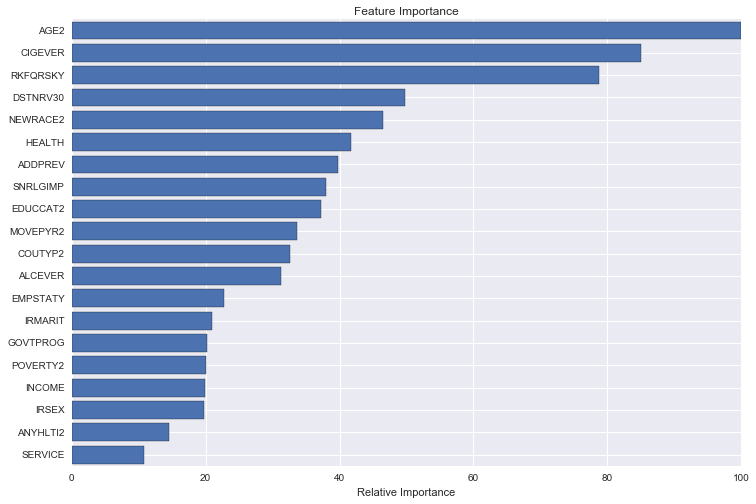

In [47]:
rank_features(gradboost2)

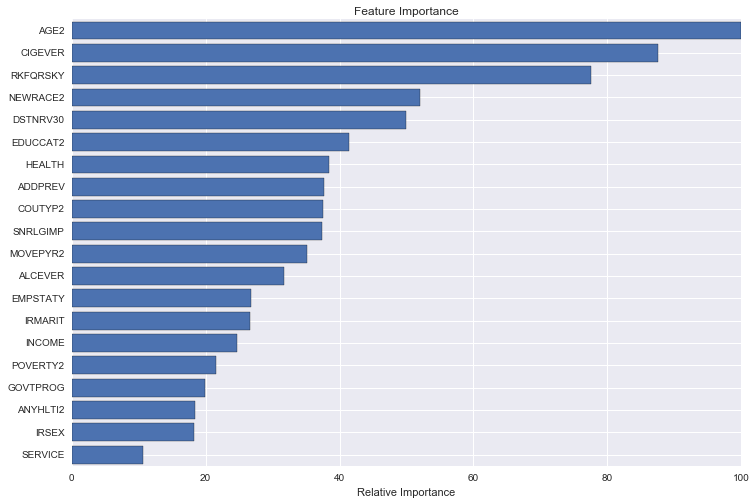

In [151]:
# Get Feature Importance from the classifier
feature_importance = gradboost3.feature_importances_
# Normalize The Features
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(12, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.asanyarray(cleanDF.columns.tolist())[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.show()

#### Trying with some XG Boosted Trees

In [48]:
# Out of the box
xgboost = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=1)

In [49]:
xgboost.fit(X_train, y_train, sample_weight=np.array([3 if i==1 else 1 for i in y_train]))

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=1)

In [50]:
xgboost_predict = xgboost.predict(X_test)
accuracy = accuracy_score(y_test, xgboost_predict)
precision = precision_score(y_test, xgboost_predict, average='binary')
recall = recall_score(y_test, xgboost_predict, average='binary')
print("Accuracy score:\t", accuracy)
print("Precision:\t", precision)
print("Recall:\t\t", recall)

Accuracy score:	 0.762193261561
Precision:	 0.37561639177
Recall:		 0.553218131731


In [51]:
y_scores = xgboost.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
auc = roc_auc_score(y_test, y_scores)
print("AUC:\t", auc)

AUC:	 0.765521569078


#### XGBoost with Grid Search Cross-Validation

In [52]:
param_test1 = {
 'max_depth': [3,5,7,9],
 'min_child_weight': [1,3,5]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train, y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.76336, std: 0.00450, params: {'min_child_weight': 1, 'max_depth': 3},
  mean: 0.76332, std: 0.00435, params: {'min_child_weight': 3, 'max_depth': 3},
  mean: 0.76323, std: 0.00480, params: {'min_child_weight': 5, 'max_depth': 3},
  mean: 0.76089, std: 0.00522, params: {'min_child_weight': 1, 'max_depth': 5},
  mean: 0.76088, std: 0.00513, params: {'min_child_weight': 3, 'max_depth': 5},
  mean: 0.76094, std: 0.00497, params: {'min_child_weight': 5, 'max_depth': 5},
  mean: 0.75279, std: 0.00546, params: {'min_child_weight': 1, 'max_depth': 7},
  mean: 0.75328, std: 0.00565, params: {'min_child_weight': 3, 'max_depth': 7},
  mean: 0.75380, std: 0.00578, params: {'min_child_weight': 5, 'max_depth': 7},
  mean: 0.73945, std: 0.00707, params: {'min_child_weight': 1, 'max_depth': 9},
  mean: 0.74064, std: 0.00559, params: {'min_child_weight': 3, 'max_depth': 9},
  mean: 0.74248, std: 0.00646, params: {'min_child_weight': 5, 'max_depth': 9}],
 {'max_depth': 3, 'min_child_weight': 1

In [53]:
param_test2 = {
 'max_depth': [4,5,6],
 'min_child_weight': [4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=3,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train, y_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.76315, std: 0.00497, params: {'min_child_weight': 4, 'max_depth': 4},
  mean: 0.76315, std: 0.00501, params: {'min_child_weight': 5, 'max_depth': 4},
  mean: 0.76267, std: 0.00504, params: {'min_child_weight': 6, 'max_depth': 4},
  mean: 0.76083, std: 0.00522, params: {'min_child_weight': 4, 'max_depth': 5},
  mean: 0.76094, std: 0.00497, params: {'min_child_weight': 5, 'max_depth': 5},
  mean: 0.76070, std: 0.00500, params: {'min_child_weight': 6, 'max_depth': 5},
  mean: 0.75813, std: 0.00526, params: {'min_child_weight': 4, 'max_depth': 6},
  mean: 0.75816, std: 0.00536, params: {'min_child_weight': 5, 'max_depth': 6},
  mean: 0.75785, std: 0.00548, params: {'min_child_weight': 6, 'max_depth': 6}],
 {'max_depth': 4, 'min_child_weight': 4},
 0.76314751078879473)

In [54]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train, y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.76315, std: 0.00497, params: {'gamma': 0.0},
  mean: 0.76295, std: 0.00499, params: {'gamma': 0.1},
  mean: 0.76282, std: 0.00506, params: {'gamma': 0.2},
  mean: 0.76300, std: 0.00494, params: {'gamma': 0.3},
  mean: 0.76317, std: 0.00465, params: {'gamma': 0.4}],
 {'gamma': 0.4},
 0.76317461673381515)

In [55]:
# with tuned parameters from GridSearch
xgboost2 = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.4, learning_rate=0.01, max_delta_step=0, max_depth=4,
       min_child_weight=4, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0.005, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=1)

In [57]:
xgboost2.fit(X_train, y_train, sample_weight=np.array([3 if i==1 else 1 for i in y_train]))

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.4, learning_rate=0.01, max_delta_step=0, max_depth=4,
       min_child_weight=4, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0.005, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=1)

In [58]:
xgboost_predict2 = xgboost2.predict(X_test)
accuracy = accuracy_score(y_test, xgboost_predict2)
precision = precision_score(y_test, xgboost_predict2, average='binary')
recall = recall_score(y_test, xgboost_predict2, average='binary')
print("Accuracy score:\t", accuracy)
print("Precision:\t", precision)
print("Recall:\t\t", recall)

Accuracy score:	 0.761583053655
Precision:	 0.375652466745
Recall:		 0.558727773604


In [59]:
y_scores = xgboost2.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
auc = roc_auc_score(y_test, y_scores)
print("AUC:\t", auc)

AUC:	 0.766889814431
